# **State Schema**

Let's explore different ways to define and validate state schemas in LangGraph. A state schema essentially defines how data is structured, what type of data is expected, and how different nodes in the graph interact with it.

There are three major ways to define state schemas.

* TypedDict,

* dataclasses,

* Pydantic,

These three provide varying levels of type safety and runtime validation.

In [1]:
%%capture --no-stderr
%pip install -qU langgraph

## **TypedDict State:**

TypedDict is a type hint that allows you to define dictionaries with specific keys and value types. It's useful for static type checking.

But, note that these are type hints.

They can used by static type checkers (like mypy) or IDEs to catch potential type-related errors before the code is run.

But they are not enforced at runtime!

In [ ]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

This example defines a TypedDictState where both foo and bar are expected to be strings.

### **Literal:**

For more specific value constraints, we can use things like the Literal type hint.

In [ ]:
from typing import Literal
class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

Here, a Literal type hint ensures that the mood key only accepts two values: "happy" or "sad".

This helps provide more specific constraints compared to generic types.

### **Node Implementation:**

In [ ]:
# Define Nodes
def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

In [ ]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define Custom Function
def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

# Build Graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile Graph
graph = builder.compile()

# Display Graph
display(Image(graph.get_graph().draw_mermaid_png()))

Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the name key in our state.

In [ ]:
graph.invoke({"name":"User"})

The graph is invoked with an initial state (name = "User"), which sets the initial value for the state key name.


## **Dataclass State:**

Dataclasses in Python provide a concise way to define classes used for storing data.

Unlike TypedDict, dataclasses are more flexible and can provide additional features like immutability.

In [6]:
from dataclasses import dataclass
from typing import Literal

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

### **Node Implementation:**

In [3]:
def node_1(state):
    return {"name": state.name + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

Notice the difference here. Since we are now using a dataclass, we access the fields using dot notation (state.name), unlike state["name"] in TypedDict.

You'll notice something a bit odd: the node still returns a dictionary to perform the state updates.

This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the dataclass has key name so we can update it by passing a dict from our node, just as we did when state was a TypedDict.

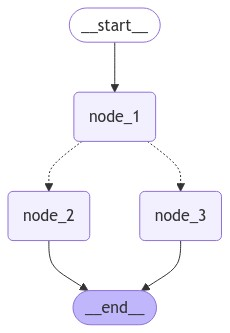

In [8]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define Custom Function
def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

# Build Graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile Graph
graph = builder.compile()

# Display Graph
display(Image(graph.get_graph().draw_mermaid_png()))

We pass an instance of DataclassState to the graph's invoke method, setting both the name and mood fields.

In [6]:
graph.invoke(DataclassState(name="User",mood="sad"))

---Node 2---


{'name': 'User is ... ', 'mood': 'happy'}



As mentioned, TypedDict and dataclasses provide type hints but they don't enforce types at runtime.

This means you could potentially assign invalid values without raising an error!

For example, we can set mood to mad even though our type hint specifies mood

In [7]:
graph.invoke(DataclassState(name="User",mood="mad"))

---Node 2---


{'name': 'User is ... ', 'mood': 'happy'}

## **Pydantic State:**

Pydantic offers runtime data validation, ensuring that the state values conform to the expected types and constraints.

It's particularly well-suited for defining state schemas in LangGraph due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

### **PydanticState Model:**

In [2]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str  # "happy" or "sad"

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

**BaseModel:** This class is provided by Pydantic, which is used to define data models with type checking and validation. It's similar to defining a schema where you specify the data structure and the expected types.

* **name:** This field must be a string (str).
* **mood:** This field must also be a string (str), but there will be a custom validation to ensure that the value is either "happy" or "sad."

**Custom Validator:**

**@field_validator('mood'):** This decorator is applied to the validate_mood method to specify that this function will validate the mood field. Whenever a PydanticState object is created, the value of mood will be passed through this validator.

**@classmethod:** This makes the validate_mood function a class method, meaning it can access the class (cls) as the first argument. Class methods are bound to the class, not instances of the class.

**cls:** Refers to the class (PydanticState) itself. You don't need to use it here, but it's part of the signature for a classmethod.

**value:** This is the actual value being passed to the mood field when an instance of PydanticState is created. The method checks if this value is either "happy" or "sad."

If the mood value is neither "happy" nor "sad," the method raises a ValueError, ensuring the invalid value is caught during validation.

### **Try/Except for Validation:**

In [3]:
try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


**ValidationError:** If the value for mood is invalid (i.e., not "happy" or "sad"), Pydantic will raise a ValidationError. The try/except block captures this error and prints it.

In this case, "mad" is not a valid mood, so the validation will fail and print an error message.

### **Node Implementation:**

In [4]:
def node_1(state):
    return {"name": state.name + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

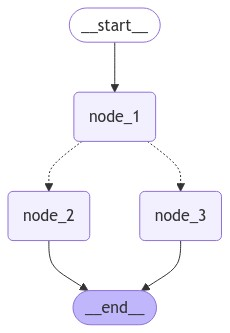

In [7]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Literal

# Define Custom Function
def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

# Build Graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile Graph
graph = builder.compile()

# Display Graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke(PydanticState(name="user",mood="sad"))

---Node 2---


{'name': 'user is ... ', 'mood': 'happy'}